# CCA + GNB on Object Exploration (binary classification) for trial stability

Here we train a classifier on trial n and test on trial m for the two object explorations. We analize performance when the training is done in the same trial as testing vs performance when training and testing in different trials, and the stability after d distance from trial (where d can be either positive or negative depending on the temporal arrangment of training and testing sets).

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn import svm
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [52]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165       ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf=1            ## value of resampling
session_now = 1

BINS = 70
FR_limit = 15
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [53]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_unsup = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_unsupervised/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/decoding/'

In [54]:
confusion_matrix_data_list = []
performance_sup = np.zeros((10,4))
performance_sup_std = np.zeros((10,4))

confusion_matrix_cca_list = []
performance_cca = np.zeros((10,4))
performance_cca_std = np.zeros((10,4))

# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0
confusion_matrix_data = []
confusion_matrix_pca = []
confusion_matrix_cca = []

print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
        
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)

    day = day + 1
    print(day)
        

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
1
2
3
4


In [55]:
    ## define targets of behaviour according to protocol (random, overlapping and stable)

    id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')

    if colapse_behaviour == 0 : # RANDOM
        for day in range(len(behaviour_list)):
            for trial in range(5):
                behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                objects = np.unique(behaviour_trial)
                selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                index0 = np.where(behaviour_trial==objects[selected_object])[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4            

                index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4 

                behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        for day in range(len(behaviour_list)):
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 3
            behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 4        
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 3
            behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 4        


    if colapse_behaviour == 2: #STABLE
        for day in range(len(behaviour_list)):
            objects = np.unique(behaviour_list[day])
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4      

            index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4  

            

REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [57]:
print('DIMENSIONALITY REDUCCION AND TRAIN CLASSIFIER')
            
dim = 2
kfold_number = 10
kf = KFold(n_splits=kfold_number)
gnb = GaussianNB()
cca = CCA(n_components=8)
 
performace_day_gnb_cca = []
performace_day_gnb_cca_std = []

performace_day_gnb_cca_shuffle = []
performace_day_gnb_cca_std_shuffle = []

for day in [0,1,2,3]:
    
    print('Decoding Exploration in day:' + f'{day+1}')
    
    ### prepare neural data
    Xpre_all = activity_list[day].T
    ### select non interneurons cells
    firing_rate = np.mean(Xpre_all,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpre_all = Xpre_all[:,selected_cells]
    
    ### select in track part of experiment where there is exploration
    index_track = np.where(behaviour_list[day]>2)[0]
    ybehaviour = behaviour_list[day][index_track]
    yparameters = parameters_list[day][:,index_track]
    Xpre_day = Xpre_all[index_track,:]

    # selected_temporal_bins for preserving class balance (here classes are not balanced)
    selected_temporal_bins = np.arange(0,Xpre_day.shape[0])
    X_day = Xpre_day[selected_temporal_bins,:]
    ybehaviour_day = ybehaviour[selected_temporal_bins]
    yparameters_day = yparameters[:,selected_temporal_bins]
        
    i= 0
    scores = np.zeros((10,))
    for train_index, test_index in kf.split(X_day):
        X_train_cca, X_test_cca = X_day[train_index], X_day[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]
            
        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1
    
    performace_day_gnb_cca.append(np.mean(scores))
    performace_day_gnb_cca_std.append(np.std(scores))
     
    ### do the same in shuffling data
    block = 5
    size = np.floor(X_day.shape[0]/block).astype(int)
    order = np.random.permutation(np.arange(0,size*block).reshape(size,block)).reshape(size*block,)
    X_day_shuffle = np.random.permutation(X_day)
    X_day_shuffle[0:size*block,:] = X_day[order,:]
    i= 0
    scores = np.zeros((10,))
    for train_index, test_index in kf.split(X_day_shuffle):
        X_train_cca, X_test_cca = X_day_shuffle[train_index], X_day_shuffle[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]
            
        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1
    
    performace_day_gnb_cca_shuffle.append(np.mean(scores))
    performace_day_gnb_cca_std_shuffle.append(np.std(scores))
    

DIMENSIONALITY REDUCCION AND TRAIN CLASSIFIER
Decoding Exploration in day:1
Decoding Exploration in day:2
Decoding Exploration in day:3
Decoding Exploration in day:4


In [58]:
           
dim = 2
kfold_number = 10
kf = KFold(n_splits=kfold_number)
gnb = GaussianNB()

cca_training_list = []
cca_gnb_training_list = []
testing_input_list = []
testing_output_list = []
 

cca_training_list_shuffle = []
cca_gnb_training_list_shuffle = []
testing_input_list_shuffle = []
testing_output_list_shuffle = []

for day in [0,1,2,3]:
    ##trial to trail train and test decoder
    Xpreall = activity_list[day].T
    firing_rate = np.mean(Xpreall,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpreall = Xpreall[:,selected_cells]
    
    for trial in range(5):
        
        print('Trial = ' + f'{day*5+trial+1}')
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        Xpre = Xpreall[time0:time1,:]     
        tracking_trial = tracking_list[day][:,time0:time1]
        behaviour_trial = behaviour_list[day][time0:time1]
        parameters_trial = parameters_list[day][:,time0:time1]
        index_track = np.where(behaviour_trial>2)[0]
        
        #define list to save classifier for each kfold iteration
        cca_training = []
        gnb_cca_training = []
          
        test_input_kfold = []
        test_output_kfold = []
        
        #define list to save classifier for each kfold iteration
        cca_training_shuffle = []
        gnb_cca_training_shuffle = []
          
        test_input_kfold_shuffle = []
        test_output_kfold_shuffle = []
          
        if index_track.shape[0] > 0:
            
            ybehaviour= behaviour_trial[index_track]
            yparameters = parameters_trial[:,index_track]

            ### prepare neural data
            Xpre = Xpre[index_track,:]     

            ### solve class inbalance by taking the minimun occupancy lengh supervised
#             min_exploration = Xpre.shape[0]
#             for i in range(3,5):
#                 exploration = np.where(ybehaviour == i)[0].shape[0]
#                 if exploration < min_exploration and exploration!=0: min_exploration = exploration 
#             selected_temporal_bins = []
#             for i in range(3,5):
#                 exploration = list(np.where(ybehaviour == i)[0])
#                 selection = random.sample(exploration, min_exploration)
#                 selected_temporal_bins = selected_temporal_bins + selection
                
            selected_temporal_bins = np.arange(0,Xpre.shape[0])
            X = Xpre[selected_temporal_bins,:]

            ybehaviour = ybehaviour[selected_temporal_bins]
            yparameters = yparameters[:,selected_temporal_bins]
          
            #select training and testing datasets
            for train_index, test_index in kf.split(X):
                X_train, X_test= X[train_index], X[test_index]
                y_train_params, y_test_params = yparameters[:,train_index], yparameters[:,test_index]
                y_train, y_test = ybehaviour[train_index], ybehaviour[test_index]
                
                #save testing data for this kfold
                test_input_kfold.append(X_test)
                test_output_kfold.append(y_test)
                        
                #train cca+classifier
                cca_training.append(CCA(n_components = 8).fit(X_train, y_train_params.T))   
                gnb_cca_training.append(GaussianNB().fit(CCA(n_components = 8).fit(X_train, y_train_params.T).transform(X_train),y_train))
        
            #select training and testing datasets
            size = np.floor(X.shape[0]/block).astype(int)
            order = np.random.permutation(np.arange(0,size*block).reshape(size,block)).reshape(size*block,)
            Xshuffle = Xpre
            Xshuffle[0:size*block,:] = Xshuffle[order,:]
            
            for train_index, test_index in kf.split(Xshuffle):
                X_train, X_test= Xshuffle[train_index], Xshuffle[test_index]
                y_train_params, y_test_params = yparameters[:,train_index], yparameters[:,test_index]
                y_train, y_test = ybehaviour[train_index], ybehaviour[test_index]
                
                #save testing data for this kfold
                test_input_kfold_shuffle.append(X_test)
                test_output_kfold_shuffle.append(y_test)
                        
                #train cca+classifier
                cca_training_shuffle.append(CCA(n_components = 8).fit(X_train, y_train_params.T))   
                gnb_cca_training_shuffle.append(GaussianNB().fit(CCA(n_components = 8).fit(X_train, y_train_params.T).transform(X_train),y_train))
        
        cca_training_list.append(cca_training)
        cca_gnb_training_list.append(gnb_cca_training)
        
        testing_output_list.append(test_output_kfold)
        testing_input_list.append(test_input_kfold)
        
        cca_training_list_shuffle.append(cca_training_shuffle)
        cca_gnb_training_list_shuffle.append(gnb_cca_training_shuffle)
        
        testing_output_list_shuffle.append(test_output_kfold_shuffle)
        testing_input_list_shuffle.append(test_input_kfold_shuffle)

Trial = 1
Trial = 2
Trial = 3
Trial = 4
Trial = 5
Trial = 6
Trial = 7
Trial = 8
Trial = 9
Trial = 10
Trial = 11
Trial = 12
Trial = 13
Trial = 14
Trial = 15
Trial = 16
Trial = 17
Trial = 18
Trial = 19
Trial = 20


In [59]:
len(cca_training_list[0])

10

In [63]:
score_matrix_gnb_cca_list = []
score_matrix_gnb_cca_list_shuffle = []


for day in range(4):
    print(day)
    score_matrix_gnb_cca = np.zeros((5,5))
    score_matrix_gnb_cca_shuffle = np.zeros((5,5))

    counter = np.zeros((5,5))
    for trial_train in range(5):
        i = day*5 + trial_train
        if len(cca_training_list[i]):
            for trial_test in range(5):
                j = day*5+trial_test 
                if len(cca_training_list[j]):
                    #if i != 10 and j!=10:      
                    for k in range(kfold_number):

                        for l in range(kfold_number):


                            if trial_train != trial_test or (trial_train == trial_test and k!=l):

                                counter[trial_train,trial_test ]+=1
                                ##score gnb+cca

                                data_transformation = cca_training_list[i][k].transform(testing_input_list[j][l])
                                classifier = cca_gnb_training_list[i][k]
                                score_gnb_cca = classifier.score(data_transformation,testing_output_list[j][l])

                                score_matrix_gnb_cca[trial_train,trial_test ]+= score_gnb_cca

                                ## shuffling
                                data_transformation = cca_training_list_shuffle[i][k].transform(testing_input_list_shuffle[j][l])
                                classifier = cca_gnb_training_list_shuffle[i][k]
                                score_gnb_cca_shuffle = classifier.score(data_transformation,testing_output_list_shuffle[j][l])

                                score_matrix_gnb_cca_shuffle[trial_train,trial_test ]+= score_gnb_cca_shuffle

    score_matrix_gnb_cca_list.append(score_matrix_gnb_cca)
    score_matrix_gnb_cca_list_shuffle.append(score_matrix_gnb_cca_shuffle)
print(counter)

0
1
2
3
[[ 90. 100. 100. 100. 100.]
 [100.  90. 100. 100. 100.]
 [100. 100.  90. 100. 100.]
 [100. 100. 100.  90. 100.]
 [100. 100. 100. 100.  90.]]


In [64]:
score_matrix_gnb_cca_list_shuffle[1]

array([[78.02205731, 66.34090414, 63.74637681, 54.14801066, 66.27022375],
       [41.96474954, 78.61072985, 36.32924264, 47.74481249, 38.53227194],
       [44.95269017, 46.73180828, 78.46902758, 49.12802208, 41.32271945],
       [58.49618635, 61.45675381, 60.09502104, 76.87940225, 63.3605852 ],
       [53.46866625, 56.53638344, 55.51145395, 52.14810584, 79.09738956]])

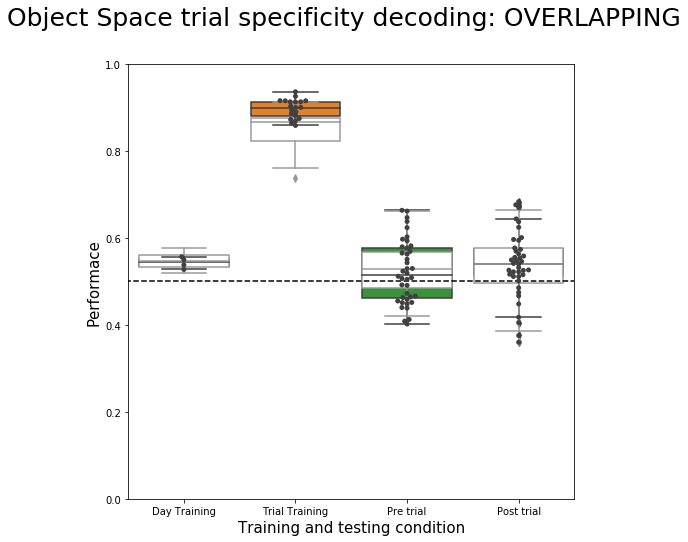

In [65]:
post_trial = []
pre_trial = []
same_trial = []

post_trial_shuffle = []
pre_trial_shuffle = []
same_trial_shuffle = []

for day in [0,1,2,3]:
    matrix = score_matrix_gnb_cca_list[day]/counter 
    matrix_shuffle = score_matrix_gnb_cca_list_shuffle[day]/counter 
    for i in range(matrix.shape[0]):
        same_trial.append(matrix.diagonal()[i])
        same_trial_shuffle.append(matrix_shuffle.diagonal()[i])
        
    tril = np.tril(matrix,k=-1).flatten()
    tril = tril[tril>0]
    for i in range(tril.shape[0]):
        pre_trial.append(tril[i])
        
    tril = np.tril(matrix_shuffle,k=-1).flatten()
    tril = tril[tril>0]
    for i in range(tril.shape[0]):
        pre_trial_shuffle.append(tril[i])    
        
    triu = np.tril(matrix.T,k=-1).flatten()
    triu = triu[triu>0]
    for i in range(tril.shape[0]):
        post_trial.append(triu[i])
        
    triu = np.tril(matrix_shuffle.T,k=-1).flatten()
    triu = triu[triu>0]
    for i in range(tril.shape[0]):
        post_trial_shuffle.append(triu[i])

fig, ax = plt.subplots(figsize = (8,8))
plot_list = np.array([performace_day_gnb_cca, same_trial, pre_trial, post_trial])
plot_list_shuffle = np.array([performace_day_gnb_cca_shuffle, same_trial_shuffle, pre_trial_shuffle, post_trial_shuffle])

###z-score values

#import pandas as pd
#plot_all = {'Day': performace_day_gnb_cca, 'DayShuffling': performace_day_gnb_cca_shuffle, 'SameTrial': same_trial, 'SameTrial_S': same_trial_shuffle }
#print(plot_all)
#plot_data = pd.DataFrame.from_dict(plot_all)
#ax[0] = sns.boxplot(data = plot_list_zscore, orient = 'v')

label = ['Day Training', 'Trial Training', 'Pre trial', 'Post trial', ]
ax= sns.boxplot(data = plot_list, orient = 'v')
ax = sns.boxplot(data = plot_list_shuffle, orient = 'v',color = '1')
ax = sns.swarmplot(data=plot_list, color=".25")
ax.set_xticklabels(label)
ax.set_xlabel('Training and testing condition', fontsize = 15)
ax.set_ylabel('Performace', fontsize = 15)
ax.set_ylim([0,1])
ax.hlines(1/2, -10, 21, colors='k', linestyles='--') 



fig.suptitle('Object Space trial specificity decoding: ' + task , fontsize = 25)  
figure_name = figure_path +'decorder_train_test_1diff_'+f'{mouse}'+'_session_'+f'{session}'+'.png'
fig.savefig(figure_name)

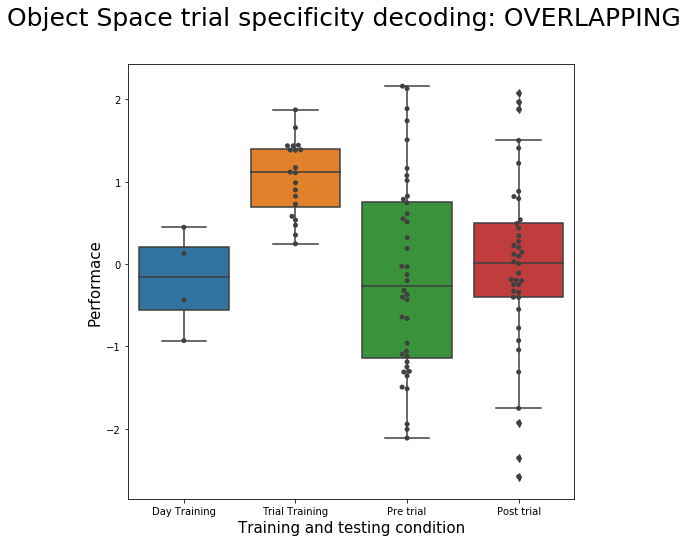

In [66]:
fig, ax = plt.subplots(figsize = (8,8))

day_performance_mean = np.mean(performace_day_gnb_cca_shuffle)
day_performance_std = np.std(performace_day_gnb_cca_shuffle)

same_trial_mean = np.mean(same_trial_shuffle)
same_trial_std = np.std(same_trial_shuffle)

pre_trial_mean = np.mean(pre_trial_shuffle)
pre_trial_std = np.std(pre_trial_shuffle)

post_trial_mean = np.mean(post_trial_shuffle)
post_trial_std = np.std(post_trial_shuffle)

plot_list = np.array([(performace_day_gnb_cca - day_performance_mean)/day_performance_std,
                      (same_trial-same_trial_mean)/same_trial_std,
                      (pre_trial-pre_trial_mean)/pre_trial_std,
                      (post_trial-post_trial_mean)/post_trial_std])


label = ['Day Training', 'Trial Training', 'Pre trial', 'Post trial', ]
ax= sns.boxplot(data = plot_list, orient = 'v')
ax = sns.swarmplot(data=plot_list, color=".25")
ax.set_xticklabels(label)
ax.set_xlabel('Training and testing condition', fontsize = 15)
ax.set_ylabel('Performace', fontsize = 15)
#ax.set_ylim([0,1])
#ax.hlines(1/2, -10, 21, colors='k', linestyles='--') 



fig.suptitle('Object Space trial specificity decoding: ' + task , fontsize = 25)  
figure_name = figure_path +'decorder_train_test_1diff_zscored_'+f'{mouse}'+'_session_'+f'{session}'+'.png'
fig.savefig(figure_name)

0
1
2
3


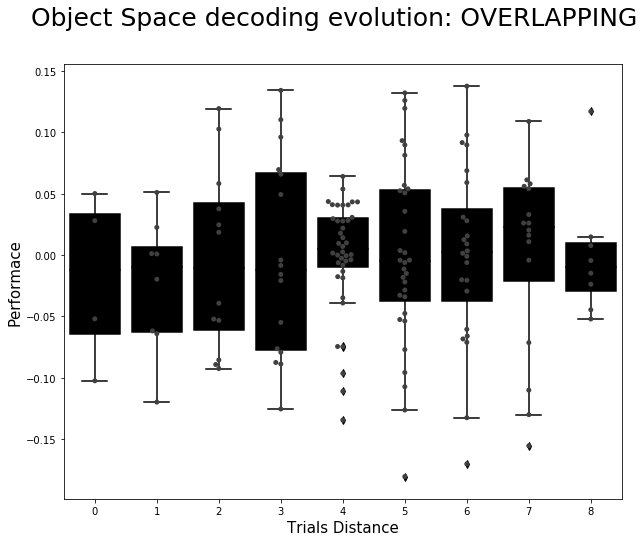

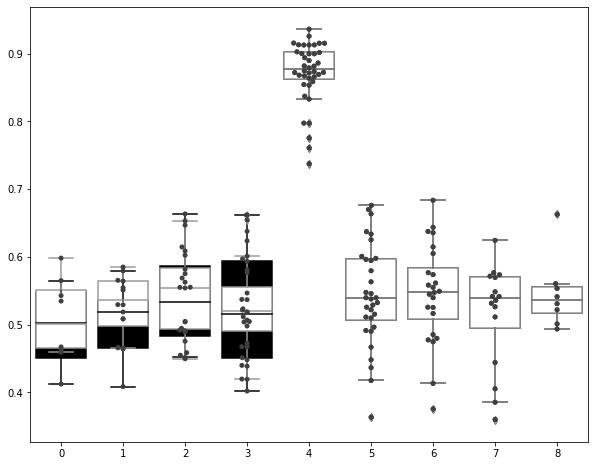

In [70]:
main_diagonal = []
first_diagonal = []
second_diagonal = []
third_diagonal = []
fourth_diagonal = []

offset_list = [[],[],[],[],main_diagonal,first_diagonal,second_diagonal,third_diagonal,fourth_diagonal]
offset_list_shuffle = [[],[],[],[],main_diagonal,first_diagonal,second_diagonal,third_diagonal,fourth_diagonal]

for day in [0,1,2,3]:
    matrix = score_matrix_gnb_cca_list[day]/counter
    matrix_shuffle = score_matrix_gnb_cca_list_shuffle[day]/counter
    print(day)
    for offset in [-4,-3,-2,-1]:
        offset_values = matrix.diagonal(offset = offset)
        offset_values_shuffle = matrix_shuffle.diagonal(offset = offset)
        for i in range(offset_values.shape[0]):
            offset_list[offset+4].append(offset_values[i])
            offset_list_shuffle[offset+4].append(offset_values_shuffle[i])

    for offset in range(0,5):
        offset_values = matrix.diagonal(offset = offset)
        offset_values_shuffle = matrix_shuffle.diagonal(offset = offset)
        for i in range(offset_values.shape[0]):
            offset_list[offset+4].append(offset_values[i])
            offset_list_shuffle[offset+4].append(offset_values_shuffle[i])

offset_list_zscore = []            
for i in range(len(offset_list)):
    offset_list_zscore.append((offset_list[i]-np.mean(offset_list_shuffle[i])))
    
            
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.boxplot(data = offset_list_zscore, orient = 'v', color = '0.0')
ax = sns.swarmplot(data= offset_list_zscore, color="0.25")
                              
# ax = sns.boxplot(data = offset_list_shuffle, orient = 'v', color = '0.9')
# ax = sns.swarmplot(data= offset_list_shuffle, color=".25")
                              
ax.set_xlabel('Trials Distance', fontsize = 15)
ax.set_ylabel('Performace', fontsize = 15)
#ax.set_ylim([0,1])
#ax.hlines(1/2, -20, 21, colors='k', linestyles='--') 


fig.suptitle('Object Space decoding evolution: ' + task , fontsize = 25)  

figure_name = figure_path +'decorder_train_test_evolution_'+f'{mouse}'+'_session_'+f'{session}'+'.png'

fig.savefig(figure_name)


fig, ax = plt.subplots(figsize = (10,8))
      
ax = sns.boxplot(data = offset_list, orient = 'v', color = '0.0')
ax = sns.swarmplot(data= offset_list, color="0.25")
               
ax = sns.boxplot(data = offset_list_shuffle, orient = 'v', color = '1')
ax = sns.swarmplot(data= offset_list_shuffle, color=".25")
         

## Training and testing at beggining and end of the same trial

In [74]:
dim = 2
kfold_number = 5
temporal_splits = 3
kf = KFold(n_splits=kfold_number)
kf2 = KFold(n_splits=temporal_splits)

gnb = GaussianNB()

cca_training_list = []
cca_gnb_training_list = []
testing_input_list = []
testing_output_list = []
 

cca_training_list_shuffle = []
cca_gnb_training_list_shuffle = []
testing_input_list_shuffle = []
testing_output_list_shuffle = []

for day in [0,1,2,3]:
    
    ### prepare neural data
    Xpre_all = activity_list[day].T
    firing_rate = np.mean(Xpre_all,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpre_all = Xpre_all[:,selected_cells]
    
    index_track = np.where(behaviour_list[day]>2)[0]
    ybehaviour = behaviour_list[day][index_track]
    yparameters = parameters_list[day][:,index_track]

    ##trial to trail train and test decoder
    for trial in range(5):
        
        print('Trial = ' + f'{day*5+trial+1}')
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        tracking_trial = tracking_list[day][:,time0:time1]
        behaviour_trial = behaviour_list[day][time0:time1]
        parameters_trial = parameters_list[day][:,time0:time1]
        index_track = np.where(behaviour_trial>2)[0]
        
        #define list to save classifier for each kfold iteration
        cca_training0 = []
        gnb_cca_training0 = []
          
        test_input_kfold0 = []
        test_output_kfold0 = []
        
        #define list to save classifier for each kfold iteration
        cca_training_shuffle = []
        gnb_cca_training_shuffle = []
          
        test_input_kfold_shuffle = []
        test_output_kfold_shuffle = []
          
        if index_track.shape[0] > 0:
            
            ybehaviour= behaviour_trial[index_track]
            yparameters = parameters_trial[:,index_track]

            ### prepare neural data
            Xpre = Xpre_all[time0:time1,:]
            Xpre = Xpre[index_track,:]    
            selected_temporal_bins = np.arange(0,Xpre.shape[0])
            X = Xpre[selected_temporal_bins,:]
            
            #Xshuffle = np.random.permutation(X)
            size = np.floor(Xpre.shape[0]/10).astype(int)
            order = np.random.permutation(np.arange(0,size*10).reshape(size,10)).reshape(size*10,)
            Xshuffle = Xpre
            Xshuffle[0:size*10,:] = Xshuffle[order,:]
            
            ybehaviour = ybehaviour[selected_temporal_bins]
            yparameters = yparameters[:,selected_temporal_bins]
            
            #separate data set in two
            
            
            for train_trial, test_trial in kf2.split(np.arange(0,X.shape[0])):
                #print(train_trial)
                #select training and testing datasets
                X_train0, X_test0= X[train_trial], X[test_trial]
                y_train_params0, y_test_params0 = yparameters[:,train_trial], yparameters[:,test_trial]
                y_train0, y_test0 = ybehaviour[train_trial], ybehaviour[test_trial]

                cca_training = []
                gnb_cca_training = []

                test_input_kfold = []
                test_output_kfold = []  
                                                     
                for train_index, test_index in kf.split(X_train0):
                    X_train, X_test= X_train0[train_index], X_train0[test_index]
                    y_train_params, y_test_params = y_train_params0[:,train_index], y_train_params0[:,test_index]
                    y_train, y_test = y_train0[train_index], y_train0[test_index]

                    #save testing data for this kfold
                    test_input_kfold.append(X_test)
                    test_output_kfold.append(y_test)

                    #train cca+classifier
                    cca_training.append(CCA(n_components = 5).fit(X_train, y_train_params.T))   
                    gnb_cca_training.append(GaussianNB().fit(CCA(n_components = 5).fit(X_train, y_train_params.T).transform(X_train),y_train))
                
                cca_training0.append(cca_training)
                gnb_cca_training0.append(gnb_cca_training)

                test_output_kfold0.append(test_output_kfold)
                test_input_kfold0.append(test_input_kfold)
                
                
             #select training and testing datasets
            for train_index, test_index in kf.split(Xshuffle):
                X_train, X_test= Xshuffle[train_index], Xshuffle[test_index]
                y_train_params, y_test_params = yparameters[:,train_index], yparameters[:,test_index]
                y_train, y_test = ybehaviour[train_index], ybehaviour[test_index]
                
                 #save testing data for this kfold
                test_input_kfold_shuffle.append(X_test)
                test_output_kfold_shuffle.append(y_test)
                       
                 #train cca+classifier
                cca_training_shuffle.append(CCA(n_components = 5).fit(X_train, y_train_params.T))   
                gnb_cca_training_shuffle.append(GaussianNB().fit(CCA(n_components = 5).fit(X_train, y_train_params.T).transform(X_train),y_train))
        
        cca_training_list.append(cca_training0)
        cca_gnb_training_list.append(gnb_cca_training0)
        
        testing_output_list.append(test_output_kfold0)
        testing_input_list.append(test_input_kfold0)
        
#         cca_training_list_shuffle.append(cca_training_shuffle)
#         cca_gnb_training_list_shuffle.append(gnb_cca_training_shuffle)
        
#         testing_output_list_shuffle.append(test_output_kfold_shuffle)
#         testing_input_list_shuffle.append(test_input_kfold_shuffle)

Trial = 1
Trial = 2
Trial = 3
Trial = 4
Trial = 5
Trial = 6
Trial = 7
Trial = 8
Trial = 9
Trial = 10
Trial = 11
Trial = 12
Trial = 13
Trial = 14
Trial = 15
Trial = 16
Trial = 17
Trial = 18
Trial = 19
Trial = 20


In [75]:
score_matrix_gnb_cca_list = []
score_matrix_gnb_cca_list_shuffle = []

for day in range(4):
    for trial in range(5):
        i = day*5 + trial 
        score_matrix_gnb_cca = np.zeros((temporal_splits,temporal_splits))
        counter = np.zeros((temporal_splits,temporal_splits))
        for k in range(temporal_splits):
            for l in range(temporal_splits):
                for fold1 in range(kfold_number):
                    for fold2 in range(kfold_number):
                        if l != k or (k == l and fold1!=fold2):
                            
                            counter[k,l ]+=1
                            ##score gnb+cca
                            data_transformation = cca_training_list[i][k][fold1].transform(testing_input_list[i][l][fold2])
                            classifier = cca_gnb_training_list[i][k][fold1]
                            score_gnb_cca = classifier.score(data_transformation,testing_output_list[i][l][fold2])

                            score_matrix_gnb_cca[k,l]+= score_gnb_cca

                            ## shuffling
#                             data_transformation = cca_training_list_shuffle[i][k].transform(testing_input_list_shuffle[j][l])
#                             classifier = cca_gnb_training_list_shuffle[i][k]
#                             score_gnb_cca_shuffle = classifier.score(data_transformation,testing_output_list_shuffle[j][l])

#                             score_matrix_gnb_cca_shuffle[trial_train,trial_test ]+= score_gnb_cca_shuffle

        score_matrix_gnb_cca_list.append(score_matrix_gnb_cca)
#     score_matrix_gnb_cca_list_shuffle.append(score_matrix_gnb_cca_shuffle)


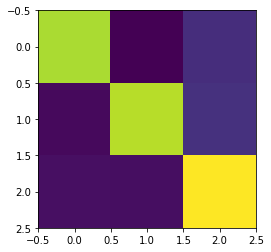

In [76]:
plt.imshow(score_matrix_gnb_cca_list[0]/counter)

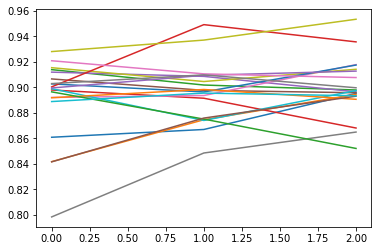

In [77]:
for i in range(20):
    plt.plot(score_matrix_gnb_cca_list[i].diagonal()/counter[0,0])

In [78]:
score_matrix_gnb_cca_list[0]/counter

array([[0.86081527, 0.62706295, 0.66165119],
       [0.63389611, 0.86692466, 0.66484761],
       [0.63855796, 0.63732645, 0.89522876]])

In [79]:
matrix_x = np.mean(score_matrix_gnb_cca_list/counter,axis = 0).diagonal()
matrix_x_std = np.std(score_matrix_gnb_cca_list/counter,axis = 0).diagonal()

diagonal_elements = []
testing_elements = []
for i in range(20):
    matrix = score_matrix_gnb_cca_list[i]/counter
    diagonal = matrix.diagonal()
    tril = np.tril(matrix,k=-1).flatten()
    tril = tril[tril>0]
    for j in range(tril.shape[0]):
        testing_elements.append(tril[j])
    triu = np.tril(matrix,k=-1).flatten()
    triu = triu[triu>0]
    for j in range(tril.shape[0]):
        testing_elements.append(triu[j])
        
    for j in range(diagonal.shape[0]):
        diagonal_elements.append(diagonal[j])
        

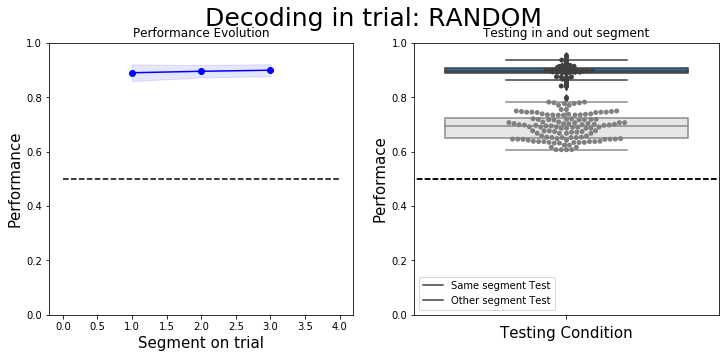

In [80]:
fig,ax = plt.subplots(1,2,figsize = (12,5))

ax[0].plot(np.arange(1,temporal_splits+1),matrix_x, color = 'b', marker='o', linestyle='-')
ax[0].fill_between(np.arange(1,temporal_splits+1),matrix_x-matrix_x_std, matrix_x + matrix_x_std,alpha = 0.1,edgecolor='b', facecolor='b')
ax[0].hlines(1/2, 0, temporal_splits+1, colors='k', linestyles='--') 
ax[0].set_ylim([0,1])
ax[0].set_ylabel('Performance',fontsize = 15)
ax[0].set_xlabel('Segment on trial', fontsize = 15)
ax[0].set_title('Performance Evolution')

ax[1] = sns.boxplot(data = diagonal_elements, orient = 'v')
ax[1] = sns.swarmplot(data= diagonal_elements, color=".25")
ax[1].set_xlabel('Testing Condition', fontsize = 15)
ax[1].set_ylabel('Performace', fontsize = 15)
ax[1].set_xticklabels(['SameSegment','LastSegment'])
ax[1].set_ylim([0,1])
ax[1].hlines(1/2, -10, 21, colors='k', linestyles='--') 
ax[1].set_title('Testing in and out segment')

ax[1] = sns.boxplot(data = testing_elements, orient = 'v', color = '0.9')
ax[1] = sns.swarmplot(data= testing_elements, color=".50")
ax[1].set_xlabel('Testing Condition', fontsize = 15)
ax[1].set_ylabel('Performace', fontsize = 15)
ax[1].set_xticklabels([''])
ax[1].set_ylim([0,1])
ax[1].hlines(1/2, -10, 21, colors='k', linestyles='--') 
ax[1].legend(['Same segment Test', 'Other segment Test'])

fig.suptitle('Decoding in trial: ' + task , fontsize = 25)  

figure_name = figure_path +'decorder_train_in_trial_evolution_'+f'{temporal_splits}'+'_'+f'{mouse}'+'_session_'+f'{session}'+'.png'

fig.savefig(figure_name)